In [1]:
dataset_path = "/kaggle/input/nlp-getting-started"

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import math
import io

from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

2024-07-04 06:26:07.346064: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 06:26:07.346257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 06:26:07.510475: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_data = pd.read_csv(dataset_path + "/train.csv")
test_data = pd.read_csv(dataset_path + "/test.csv")

train_data = train_data.sample(frac=1, random_state=42)
test_data = test_data.sample(frac=1, random_state=42)

train_data

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration s...,0
5390,7691,panic,NaN,just had a panic attack bc I don't have enough...,0
860,1242,blood,NaN,Omron HEM-712C Automatic Blood Pressure Monito...,0
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data["text"].to_numpy(),
    train_data["target"].to_numpy(),
    test_size=0.1,
    random_state=42,
)

# Text vectorization

In [5]:
max_tokens = 10_000
ngrams = None
output_sequence_length = math.ceil(np.array([len(seq.split()) for seq in X_train]).mean())

text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    ngrams=ngrams, # create groups of n-words
    output_sequence_length=output_sequence_length, # sequences of words length
)

text_vectorizer.adapt(X_train) # 训练

# Creating an embedding layer

In [6]:
text_embedding = layers.Embedding(input_dim=max_tokens,
                                 output_dim=128,
                                 input_length=output_sequence_length)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [7]:
model_4 = tf.keras.Sequential([
    layers.Input([1,], dtype=tf.string),
    text_vectorizer,
    text_embedding,
    layers.Bidirectional(layers.GRU(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(96)),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model_4.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

model_4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 15, 256)        │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 192)            │       271,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,761,665 (6.72 MB)

 Trainable params: 1,761,665 (6.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.6978 - loss: 0.5701 - val_accuracy: 0.7848 - val_loss: 0.4566
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.8715 - loss: 0.3100 - val_accuracy: 0.7769 - val_loss: 0.4702
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.9246 - loss: 0.2053 - val_accuracy: 0.7743 - val_loss: 0.5608
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.9524 - loss: 0.1399 - val_accuracy: 0.7822 - val_loss: 0.6829
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9665 - loss: 0.0943 - val_accuracy: 0.7808 - val_loss: 0.9457


<Axes: >

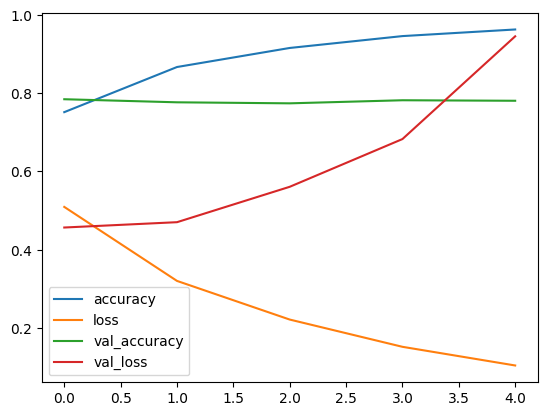

In [8]:
model_4_history = model_4.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

pd.DataFrame(model_4_history.history).plot()

In [9]:
# 进行预测
predictions = tf.round(tf.squeeze(model_4.predict(test_data['text'].to_numpy())))
predictions = tf.cast(predictions, tf.int32)
results_df = pd.DataFrame({
    'id': test_data['id'],
    'target': predictions
})
results_df

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


,id,target
2406,8051,0
134,425,0
411,1330,0
203,663,0
889,2930,0
...,...,...
1095,3606,0
1130,3731,0
1294,4259,0
860,2816,0


In [10]:
results_df.to_csv('/kaggle/working/submission3.csv', index=False)